In [13]:
##### Assignment IV ######
## Assessing Induced Polarization (IP) Signatures of Microbial-Mineral Interactions in Permafrost Environments Using Synthetic Data ##
### Applied Geophysics ###

In [14]:
# SimPEG functionality
from simpeg.electromagnetics.static import induced_polarization as ip
from simpeg.electromagnetics.static.utils.static_utils import (
    plot_pseudosection,
)
from simpeg.utils.io_utils.io_utils_electromagnetics import read_dcip2d_ubc
from simpeg.utils import download, model_builder
from simpeg import (
    maps,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
)

# discretize functionality
from discretize import TreeMesh
from discretize.utils import active_from_xyz

# Basic Python functionality
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import pandas as pd
import tarfile

mpl.rcParams.update({"font.size": 14})  # default font size
cmap = mpl.cm.RdYlBu_r  # default colormap

   SampleID   Depth_m  Temperature_C  Microbial_Activity  \
0         1  3.745401     -14.528562           64.203165   
1         2  9.507143      -5.453844            8.413996   
2         3  7.319939     -10.284660           16.162871   
3         4  5.986585      -7.371440           89.855419   
4         5  1.560186      -1.386503           60.642906   

   Mineral_Content_percent  IP_Chargeability_mV/V  
0                12.067269               5.722364  
1                31.254185               3.567122  
2                31.625405               4.652637  
3                35.497196               7.732224  
4                39.043653               7.260677  


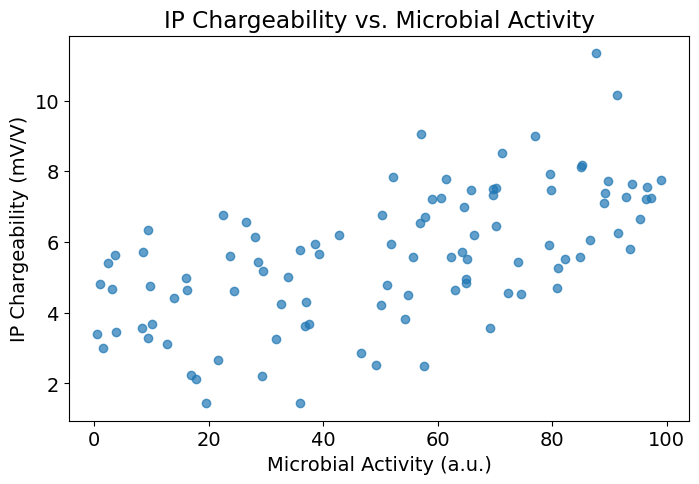

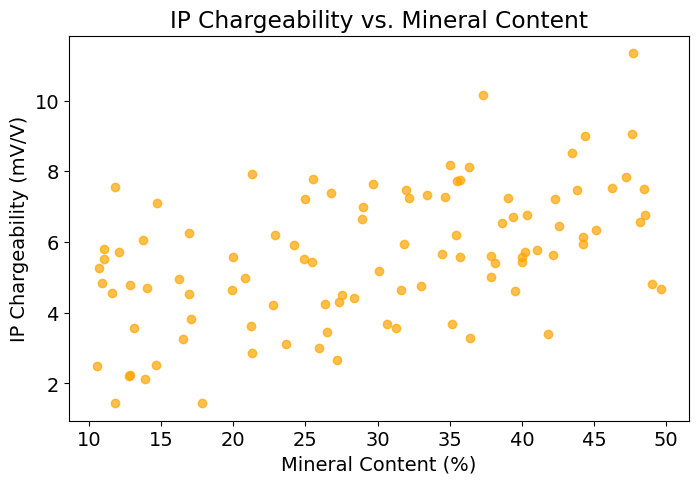

In [15]:
# For reproducibility
np.random.seed(42)

# Number of synthetic samples
n_samples = 100

# Simulate permafrost conditions:
# Depth: 0-10 m; Temperature: -15°C to 0°C (typical permafrost range)
depth = np.random.uniform(0, 10, n_samples)
temperature = np.random.uniform(-15, 0, n_samples)

# Simulate biogeochemical parameters:
# Microbial activity (arbitrary units) and mineral content (% clay)
microbial_activity = np.random.uniform(0, 100, n_samples)
mineral_content = np.random.uniform(10, 50, n_samples)

# Hypothetical model:
# IP_Chargeability (mV/V) increases with both microbial activity and mineral content,
# plus some random noise to reflect natural variability.
noise = np.random.normal(0, 1, n_samples)
ip_chargeability = 0.05 * microbial_activity + 0.1 * mineral_content + noise

# Assemble data into a DataFrame
data = pd.DataFrame({
    "SampleID": np.arange(1, n_samples+1),
    "Depth_m": depth,
    "Temperature_C": temperature,
    "Microbial_Activity": microbial_activity,
    "Mineral_Content_percent": mineral_content,
    "IP_Chargeability_mV/V": ip_chargeability
})

# Display first few rows of the dataset
print(data.head())

# Plot: IP Chargeability vs. Microbial Activity
plt.figure(figsize=(8, 5))
plt.scatter(microbial_activity, ip_chargeability, alpha=0.7)
plt.xlabel('Microbial Activity (a.u.)')
plt.ylabel('IP Chargeability (mV/V)')
plt.title('IP Chargeability vs. Microbial Activity')
plt.show()

# Plot: IP Chargeability vs. Mineral Content
plt.figure(figsize=(8, 5))
plt.scatter(mineral_content, ip_chargeability, alpha=0.7, color='orange')
plt.xlabel('Mineral Content (%)')
plt.ylabel('IP Chargeability (mV/V)')
plt.title('IP Chargeability vs. Mineral Content')
plt.show()

In [16]:
#Forward simulation
# SimPEG functionality
from simpeg.electromagnetics.static import induced_polarization as ip
from simpeg.utils import model_builder
from simpeg.utils.io_utils.io_utils_electromagnetics import write_dcip2d_ubc
from simpeg import maps, data
from simpeg.electromagnetics.static.utils.static_utils import (
    generate_dcip_sources_line,
    pseudo_locations,
    plot_pseudosection,
)

# discretize functionality
from discretize import TreeMesh
from discretize.utils import active_from_xyz

# Common Python functionality
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

mpl.rcParams.update({"font.size": 14})

write_output = False  # Optional

In [17]:
#More Forward simulation
# Along-line locations
x_topo = np.linspace(-2000, 2000, 401)

# Elevation as a function of along-line location
T = 800.0
z_topo = 20.0 * np.sin(2 * np.pi * x_topo / T) + 140.0
z_topo[x_topo < -3 * T / 4] = 160.0
z_topo[x_topo > 3 * T / 4] = 120.0
z_topo += 50.0 * (1.0 + np.tanh(-3 * (x_topo + 1200.0) / T))
z_topo -= 50.0 * (1.0 + np.tanh(3 * (x_topo - 1200.0) / T))

# Define full 2D topography
topo_2d = np.c_[x_topo, z_topo]

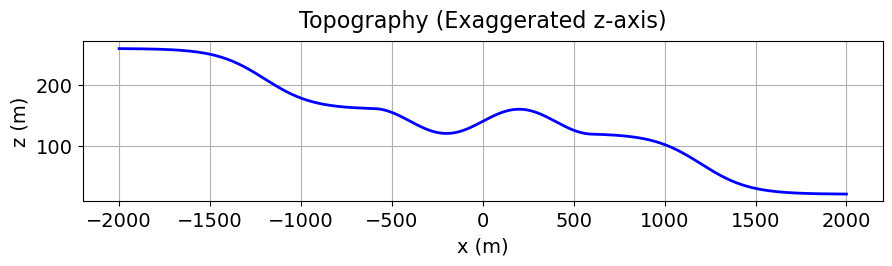

In [18]:
#Forward simulation continued
# Plot 2D topography
fig = plt.figure(figsize=(10, 2))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(x_topo, z_topo, color="b", linewidth=2)
ax.set_xlabel("x (m)", labelpad=5)
ax.set_ylabel("z (m)", labelpad=5)
ax.grid(True)
ax.set_title("Topography (Exaggerated z-axis)", fontsize=16, pad=10)
plt.show(fig)

In [19]:
# Define survey line parameters
survey_type = "dipole-dipole"
dimension_type = "2D"
data_type = "apparent_chargeability"
end_locations = np.r_[-400.0, 400.0]
station_separation = 40.0
num_rx_per_src = 10

In [20]:
ip_source_list = generate_dcip_sources_line(
    survey_type,
    data_type,
    dimension_type,
    end_locations,
    topo_2d,
    num_rx_per_src,
    station_separation,
)

ip_survey = ip.survey.Survey(ip_source_list)

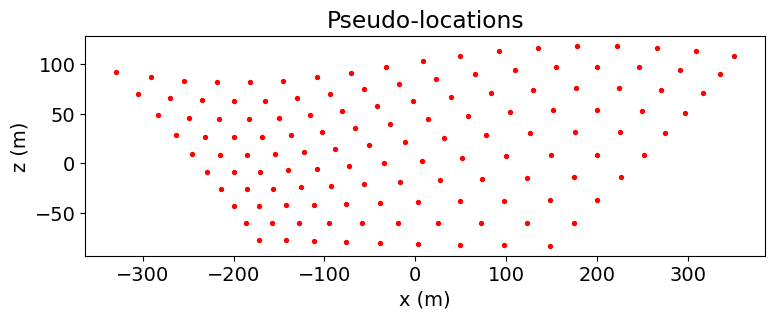

In [21]:
pseudo_locations_xz = pseudo_locations(ip_survey)
fig = plt.figure(figsize=(8, 2.75))
ax = fig.add_axes([0.1, 0.1, 0.85, 0.8])
ax.scatter(pseudo_locations_xz[:, 0], pseudo_locations_xz[:, -1], 8, "r")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
ax.set_title("Pseudo-locations")
plt.show()

In [22]:
dh = 4  # base cell width
dom_width_x = 3200.0  # domain width x
dom_width_z = 2400.0  # domain width z
nbcx = 2 ** int(np.round(np.log(dom_width_x / dh) / np.log(2.0)))  # num. base cells x
nbcz = 2 ** int(np.round(np.log(dom_width_z / dh) / np.log(2.0)))  # num. base cells z

# Define the base mesh with top at z = 0 m.
hx = [(dh, nbcx)]
hz = [(dh, nbcz)]
mesh = TreeMesh([hx, hz], x0="CN", diagonal_balance=True)

# Shift top to maximum topography
mesh.origin = mesh.origin + np.r_[0.0, z_topo.max()]

# Mesh refinement based on topography
mesh.refine_surface(
    topo_2d,
    padding_cells_by_level=[0, 0, 4, 4],
    finalize=False,
)

# Extract unique electrode locations.
unique_locations = ip_survey.unique_electrode_locations

# Mesh refinement near electrodes.
mesh.refine_points(
    unique_locations, padding_cells_by_level=[8, 12, 6, 6], finalize=False
)

mesh.finalize()

In [23]:
#Define the active cells
# Indices of the active mesh cells from topography (e.g. cells below surface)
active_cells = active_from_xyz(mesh, topo_2d)

# number of active cells
n_active = np.sum(active_cells)

In [24]:
# Define electrical conductivities in S/m
air_conductivity = 1e-8
background_conductivity = 1e-2
conductor_conductivity = 1e-1
resistor_conductivity = 1e-3

In [25]:
# Define conductivity model
conductivity_model = background_conductivity * np.ones(n_active)

ind_conductor = model_builder.get_indices_sphere(
    np.r_[-120.0, 40.0], 60.0, mesh.cell_centers[active_cells, :]
)
conductivity_model[ind_conductor] = conductor_conductivity

ind_resistor = model_builder.get_indices_sphere(
    np.r_[120.0, 72.0], 60.0, mesh.cell_centers[active_cells, :]
)
conductivity_model[ind_resistor] = resistor_conductivity

In [26]:
# Mapping from conductivity model to mesh
conductivity_map = maps.InjectActiveCells(mesh, active_cells, air_conductivity)

In [27]:
# Mapping to neglect air cells when plotting
plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan)

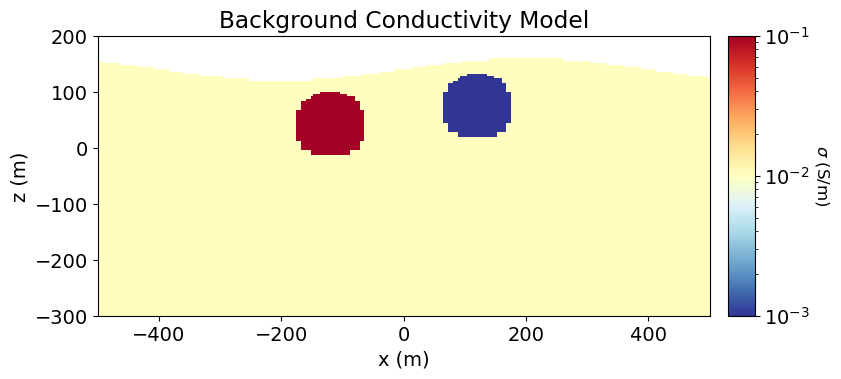

In [28]:
fig = plt.figure(figsize=(9, 4))
norm = LogNorm(vmin=1e-3, vmax=1e-1)

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * conductivity_model,
    ax=ax1,
    grid=False,
    pcolor_opts={"norm": norm, "cmap": mpl.cm.RdYlBu_r},
)
ax1.set_xlim(-500, 500)
ax1.set_ylim(-300, 200)
ax1.set_title("Background Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.84, 0.17, 0.03, 0.7])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label(r"$\sigma$ (S/m)", rotation=270, labelpad=15, size=12)

plt.show()